In [9]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch import optim

import fraud_detection as fd
from fraud_detection import metrics
from fraud_detection.neuralnets.model import load_model

path = Path("./data/transformed_label_and_damage.parquet")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

import os

os.chdir("..")


In [81]:
df = pd.read_csv("model_comparison.csv")

In [82]:
df

,Unnamed: 0,LGBMClassifier,XGBoost simple,CatBoost
0,precision,0.8244525018412662,0.8390968561660743,0.845045462852087
1,recall,0.5739178007323605,0.5641912881893206,0.5611989397168935
2,f1,0.6760928209877026,0.6741601226885178,0.6737328028492233
3,mcc,0.6800854487298572,0.6804945508025908,0.681074907518191
4,damage_total,6015.164000000001,6015.164000000001,6015.164000000001
5,damage_prevented,3671.4324000000006,3615.2260000000006,3610.3032000000003
6,damage_missed,2343.7315999999996,2399.938,2404.8608
7,detected bonus,2455.2,2413.6,2400.8
8,fp penalty,1053.2,934.0,892.0
9,Bewertung,-941.7315999999998,-920.3379999999999,-896.0608


In [15]:
os.chdir("./fraud-detection")

In [16]:
!pwd

/home/david/Hagen/projektpraktikum/projektpraktikum-datascience/fraud-detection


In [17]:
useless_features = [
    "max_product_price",
    "has_positive_price_difference",
    "has_bakery",
    "time_to_first_scan",
    "popularity_max",
    "has_age_restricted",
    "cash_desk",
    "transaction_duration_seconds",
    "feedback_low",
    "feedback_middle",
    "feedback_high",
    "feedback_top",
    "store_id",
    "location",
    "urbanization",
    "has_voided",
    "has_sold_by_weight",
    "has_limited_time_offers",
    "has_fruits_vegetables",
    "has_missing",
    "has_camera_detected_wrong_product",
    "day_of_week",
]

In [18]:
class FraudDetector:
    def __init__(self, model, scaler, name:str , threshold: float = 0.5):
        self.model = model
        self.scaler = scaler
        self._name = name
        self.threshold = threshold

    def name(self) -> str:
        return self._name

    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = self._predict_proba(X)
        preds = (probs > self.threshold).long().view(-1)
        return preds.cpu().numpy()

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        probs = self._predict_proba(X)
        return probs.cpu().numpy()

    def _predict_proba(self, X: np.ndarray) -> torch.Tensor:
        X_transformed = self.scaler.transform(X)
        Xt = torch.tensor(X_transformed, dtype=torch.float32)
        outputs = self.model.predict(Xt)
        probs = torch.sigmoid(outputs)
        return probs


In [19]:
test_size = 0.2

Xdf, ydf = fd.data_loader.load_data(path, drop_features=useless_features)
Xdf = Xdf.to_pandas()
ydf = ydf.to_pandas()

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(Xdf, ydf, test_size=test_size, random_state=seed, stratify=ydf["label"])

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy()
y_test = y_test_df.to_numpy()

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

model, _ = load_model("./models/model_epoch_10.pth", optim.AdamW)
model.eval()

clf = FraudDetector(model, scaler, "Pretrained NN", threshold=0.5)

=> Model loaded from ./models/model_epoch_10.pth


In [21]:
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)

metrics.propability_histogram(probs, y_test[:, 0], clf.name(), bins=20)
metrics.plot_roc_curve(probs, y_test[:, 0], clf.name())

bew = metrics.bewertung(preds, y_test[:, 0], y_test[:, 1])
metrics.print_metrics(bew)


cm
[[28556   118]
 [  393   463]]
precision                0.80
recall                   0.54
f1                       0.64
mcc                      0.65
damage_total          5961.94
damage_prevented      3679.84
damage_missed         2282.10
detected bonus        2315.00
fp penalty            1180.00
Bewertung            -1147.10


In [73]:
np.argmax(preds)

np.int64(61)

In [74]:
import shap

# background: a small sample of your dataset, e.g., 100 samples
background = X_train[np.random.choice(X_train.shape[0], 300, replace=False)]

explainer = shap.KernelExplainer(clf.predict_proba, background)

# explanation for a set of test inputs
shap_values = explainer.shap_values(X_test[60:70])  # Use small batches; it's slow

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

In [75]:
type(shap_values)

numpy.ndarray

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_537130/746669556.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df[:10])
/home/david/Hagen/projektpraktikum/projektpraktikum-datascience/fraud-detection/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


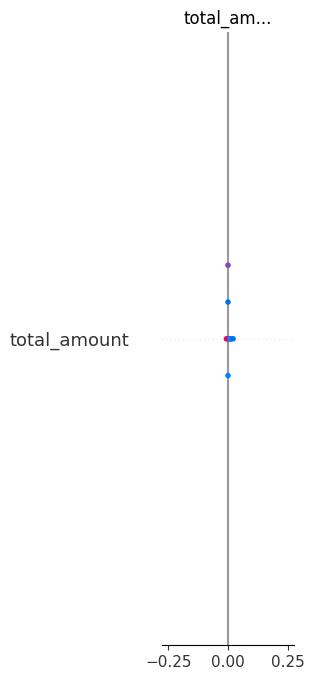

In [41]:
# Use a small background dataset for KernelExplainer (e.g., 100 samples)
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create explainer
explainer = shap.KernelExplainer(clf.predict_proba, background)

# Choose a few test points to explain
shap_values = explainer.shap_values(X_test_df[:10])

# Plot
shap.summary_plot(shap_values, X_test_df[:10])

In [51]:
shap_values[0].squeeze().shape

(58,)

In [64]:
val = shap_values[0].squeeze()
val.reshape(-1)

array([ 0.        ,  0.02396913,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.0188787 , -0.04464726,
        0.00723551,  0.05481883,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00487838, -0.04862276,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.01802234,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.02348129,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01973406,  0.        ,  0.        ])

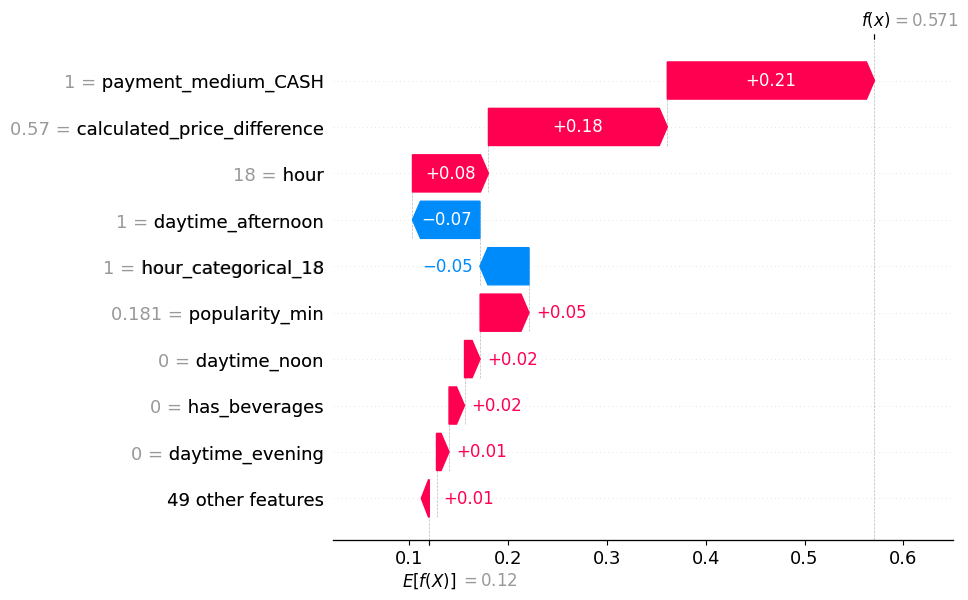

In [76]:
i  = 1
offset = 60
val = shap_values[i].squeeze()  # SHAP values for the first instance
x = X_test_df.iloc[offset +i, :]

explanation = shap.Explanation(
    values=val,
    base_values=explainer.expected_value,  # important!
    data=x.values,
    feature_names=x.index.tolist()
)

shap.plots.waterfall(explanation)